In [37]:
import pandas as pd
import numpy as np
import os
import importlib

pd.set_option('display.max_columns', 50)

## Preliminaries

Run the `create_data.py` script to generate the following files:

- `cohort.csv`:
  - Contains one record for each adult patient’s first ICU stay over 48 hours in lengthwithin their first hospital admission.
  - The `mort_icu` column represents whether the patient died during their ICU stay.
  - The columns from `Acute Renal` to `Shock` correspond to each of the 25 CCS code  groups, which are derived from  ICD-9 codes assigned at the end of a patient’s hospital stay.
  - The `Any Acute` and `Any Chronic` columns are derived from whether the patient has any acute and chronic phenotypes respectively.
  
  
- `notes.csv`
  - Contains, for each of the patients in `cohort.csv`, all of the notes written during their hospital stay (along with the timestamp) for the following note types:
      - Discharge Summary
      - Nursing
      - Nursing/other
  - The notes have been lightly preprocessed (ex: removing PHI identifiers, removing section numbers).

In [4]:
data_path = 'mimic_data/'

In [5]:
cohort = pd.read_hdf(os.path.join(data_path, 'cohort.h5'))
notes = pd.read_hdf(os.path.join(data_path, 'notes.h5'))

In [6]:
cohort.head()

,subject_id,hadm_id,icustay_id,gender,admittime,dischtime,age,ethnicity,admission_type,language,insurance,hospital_expire_flag,mort_icu,intime,Acute Renal,Cerebrovascular,Myocardial,Dysrhythmias,Chronic Kidney,COPD,Comp. Surgical,Conduction,Heart Failure,Atherosclerosis,Diabetes Comp,Diabetes No Comp,Lipid Metabolism,Hypertension,Fluid Disorder,GI Hemorrhage,Hypertension Comp,Other Liver,Lower Resp,Upper Resp,Pleurisy,Pneumonia,Resp Failure,Septicemia,Shock,Any Acute,Any Chronic,train
0,3,145834,211552,M,2101-10-20 19:08:00,2101-10-31 13:58:00,76.0,white,EMERGENCY,Missing,Medicare,0,0,2101-10-20 19:10:11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1
1,6,107064,228232,F,2175-05-30 07:15:00,2175-06-15 16:00:00,65.0,white,ELECTIVE,English,Medicare,0,0,2175-05-30 21:30:54,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
2,9,150750,220597,M,2149-11-09 13:06:00,2149-11-14 10:15:00,41.0,other,EMERGENCY,Missing,Medicaid,1,1,2149-11-09 13:07:02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3,12,112213,232669,M,2104-08-07 10:15:00,2104-08-20 02:57:00,72.0,white,ELECTIVE,Missing,Medicare,1,0,2104-08-08 02:08:17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4,13,143045,263738,F,2167-01-08 18:43:00,2167-01-15 15:15:00,39.0,white,EMERGENCY,Missing,Medicaid,0,0,2167-01-08 18:44:25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [7]:
cohort.shape

(19392, 42)

In [8]:
array1 = cohort['intime'].unique()
print(array1)
print(array1.size)

['2101-10-20T19:10:11.000000000' '2175-05-30T21:30:54.000000000'
 '2149-11-09T13:07:02.000000000' ... '2181-01-29T05:33:34.000000000'
 '2184-12-28T17:30:58.000000000' '2147-02-08T13:53:58.000000000']
19391


In [9]:
notes.head()

,note_id,subject_id,hadm_id,chartdate,charttime,category,text
0,174,22532,167853.0,2151-08-04,NaT,Discharge summary,service: addendum: radiologic s...
1,175,13702,107527.0,2118-06-14,NaT,Discharge summary,date of birth: ...
4,178,26880,135453.0,2162-03-25,NaT,Discharge summary,date of birth: ...
6,180,20646,134727.0,2112-12-10,NaT,Discharge summary,service: medicine aller...
7,181,42130,114236.0,2150-03-01,NaT,Discharge summary,date of birth: ...


In [11]:
notes.shape

(425549, 7)

In [12]:
print(notes.groupby('subject_id').size())

subject_id
3        20
6         8
9        23
12       23
13       10
         ..
99973    14
99982     1
99985    64
99991    17
99995     1
Length: 19224, dtype: int64


## Data Exploration

In [14]:
## Write code for question 2 here
# (a)What is the distribution of the cohort (in percentages) for gender, ethnicity, language, and insurance?

In [15]:
df_cohort = pd.DataFrame(cohort)

In [16]:
print("--Distribution of gender--")
series_gender = df_cohort.gender
percent_gender = series_gender.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
percent_gender

--Distribution of gender--


M    56.9%
F    43.1%
Name: gender, dtype: object

In [17]:
print("--Distribution of ethnicity--")
series_ethnicity = df_cohort.ethnicity
percent_ethnicity = series_ethnicity.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
percent_ethnicity

--Distribution of ethnicity--


white       70.1%
other       16.9%
black        7.6%
hispanic     3.2%
asian        2.3%
Name: ethnicity, dtype: object

In [18]:
print("--Distribution of language--")
series_language = df_cohort.language
percent_language = series_language.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
percent_language

--Distribution of language--


English    51.2%
Missing    40.5%
Other       8.3%
Name: language, dtype: object

In [19]:
print("--Distribution of insurance--")
series_insurance = df_cohort.insurance
percent_insurance = series_insurance.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
percent_insurance

--Distribution of insurance--


Medicare      54.0%
Private       33.7%
Medicaid       8.3%
Government     2.9%
Self Pay       1.1%
Name: insurance, dtype: object

In [20]:
# (b) What is the distribution of the cohort (in percentages) for the intersection of gender and ethnicity?

In [21]:
df_cohort['gender_ethnicity'] = df_cohort['gender'] +'_'+ df_cohort['ethnicity']
series_gender_ethnicity = df_cohort.gender_ethnicity
percent_gender_ethnicity = series_gender_ethnicity.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
percent_gender_ethnicity

M_white       40.2%
F_white       29.9%
M_other       10.0%
F_other        6.9%
F_black        4.2%
M_black        3.4%
M_hispanic     1.9%
M_asian        1.4%
F_hispanic     1.3%
F_asian        0.9%
Name: gender_ethnicity, dtype: object

## Fairness Metrics

In [22]:
%%html
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;width:100%}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-fymr{font-weight:bold;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-fymr" style="width:20%">Fairness Property</th>
    <th class="tg-fymr" style="width:40%">Definition</th>
    <th class="tg-fymr" style="width:15%">Gap Name</th>
    <th class="tg-fymr" style="width:25%">Gap Equation</th>
  </tr>
  <tr>
    <td class="tg-0pky">Demographic parity</td>
    <td class="tg-0pky">$P(\hat{Y}=y) = P(\hat{Y} = \hat{y} | Z=z),&nbsp;&nbsp;\forall z \in Z $</td>
    <td class="tg-0pky">Parity Gap</td>
    <td class="tg-0pky">$\frac{TP_1 + FP_1}{N_1} - \frac{TP_2 + FP_2}{N_2}$</td>
  </tr>
  <tr>
    <td class="tg-0pky">Equality of opportunity<br>(positive class)</td>
    <td class="tg-0pky">$P(\hat{Y}=1 | Y=1) =&nbsp;&nbsp;P(\hat{Y}=1 | Y=1, Z=z), \forall z \in Z$</td>
    <td class="tg-0pky">Recall Gap</td>
    <td class="tg-0pky">$\frac{TP_1 }{TP_1+FN_1} - \frac{TP_2 }{TP_2 + FN_2}$</td>
  </tr>
  <tr>
    <td class="tg-0pky">Equality of opportunity<br>(negative class)</td>
    <td class="tg-0pky">$P(\hat{Y}=0 | Y=0) =&nbsp;&nbsp;P(\hat{Y}=0 | Y=0, Z=z), \forall z \in Z$</td>
    <td class="tg-0pky">Specificity Gap</td>
    <td class="tg-0pky">$\frac{TN_1 }{TN_1+FP_1} - \frac{TN_2 }{TN_2 + FP_2}$</td>
  </tr>
</table>

Fairness Property,Definition,Gap Name,Gap Equation
Demographic parity,"$P(\hat{Y}=y) = P(\hat{Y} = \hat{y} | Z=z), \forall z \in Z $",Parity Gap,$\frac{TP_1 + FP_1}{N_1} - \frac{TP_2 + FP_2}{N_2}$
Equality of opportunity(positive class),"$P(\hat{Y}=1 | Y=1) = P(\hat{Y}=1 | Y=1, Z=z), \forall z \in Z$",Recall Gap,$\frac{TP_1 }{TP_1+FN_1} - \frac{TP_2 }{TP_2 + FN_2}$
Equality of opportunity(negative class),"$P(\hat{Y}=0 | Y=0) = P(\hat{Y}=0 | Y=0, Z=z), \forall z \in Z$",Specificity Gap,$\frac{TN_1 }{TN_1+FP_1} - \frac{TN_2 }{TN_2 + FP_2}$


In [34]:
import metrics    #metrics_clip.ipynb
importlib.reload(metrics)

def binary_test():
    test_df1 = pd.DataFrame(data  = {
        'protected': ['A','B']*5,
        'target': [0]*3 + [1]*7,
        'pred':[0.1, 0.8, 0.8, 0.9, 0.3, 0.3, 0.99, 0.1, 0.1, 0.9]
    })
    ret = metrics.gap_metrics(test_df1, 'protected', 'target', 'pred', 0.4)
    assert(np.allclose(ret['parity']['A'], -0.2) and
    np.allclose(ret['parity']['B'], 0.2) and
    np.allclose(ret['specificity']['A'], 0.5) and
    np.allclose(ret['specificity']['B'], -0.5) and
    np.allclose(ret['recall']['A'], -1/6) and
    np.allclose(ret['recall']['B'], 1/6)) , 'Test failed!'
    print("Test passed!")
    
binary_test()

Test passed!


## TF-IDF Model for ICU Mortality

In [24]:
# code for 4(a)

def process_data(cohort, notes):
    '''
    Processes data according to the steps in 4a
    Inputs :
        - cohort dataframe
        - notes dataframe
    Output:
        - Dataframe with (at least) the following columns:
            - subject_id, hadm_id
            - text
            - gender
            - mort_icu
            - train
    '''
    # merge two df on the column 'subject_id'
    df_new = pd.merge(cohort, notes, on='subject_id')
    print("The shape of df_new:", df_new.shape)
    
    # add a new column named "diff_days", which calculated the difference between the two coluumns
    # and the unit is in days
    df_new['diff_days'] = (df_new['charttime'] - df_new['intime'])/np.timedelta64(1,'D')
    
    #----------------------------------------------------------------------------------------------------
    # only keep the days <= 2, i.e., 48h
    df_new = df_new[df_new['diff_days'] <= 2]
    
    # remove 'Discharge summary'
    df_new = df_new[df_new['category'] != "Discharge summar"]
    
    #only keep the reuqired columns
    df_new = df_new[['subject_id', 'hadm_id_x', 'text', 'gender', 'mort_icu', 'train', 'diff_days']]
    print("The shape of df_new:", df_new.shape)
    print("--------------------df_new-----------------")
    print(df_new.head(10))
    print(df_new.count())
    
    # https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby/45925961
    # create a new df, which contanent all text in one cell
    df_text = df_new.groupby(['subject_id'])['text'].apply(' '.join).reset_index()
    
    df_text.rename(columns={'text': 'merged_text'}, inplace=True)
    
    df_text["merged_text_length"]= df_text["merged_text"].str.len()
    print("--------------------df_text-----------------")
    print(df_text.head(10))
    print(df_text.count())
    
    
    # create a new df: df for calculate mean
    # https://stackoverflow.com/questions/32965589/find-min-max-and-average-of-an-id-in-python-pandas
    df_for_mean = df_text.groupby('subject_id')['merged_text_length'].agg([pd.np.mean])
    print("--------------------df_for_mean-----------------")
    print(df_for_mean.head(10))
    print(df_for_mean.count())
    
    
    # create a new df: only contains unique subject_id
    df_new_group = df_new.drop_duplicates(subset=['subject_id'])
    df_new_group = df_new_group[['subject_id', 'hadm_id_x', 'gender', 'mort_icu', 'train', 'diff_days']]
    
    print("--------------------df_new_group-----------------")
    print(df_new_group.head(10))
    print(df_new_group.count())
    
    # merge the new df (df_text) with the original one (df_new)
    df = pd.merge(df_new_group, df_text, on='subject_id')
    df = pd.merge(df, df_for_mean, on='subject_id')
    
    # The number of patients remaining in the cohort.
    print("The number of patients remaining in the cohort are", df.shape[0])
    
    # The average length (in characters) of the notes (for those that remain).
    # So, this will also count the length of space, digits...
    
    print("--------------------df-----------------")
    print(df.head(10))
    print(df.count())
    print("The average length (in characters) of the notes is", df["merged_text_length"].mean())
    
    return df

df = process_data(cohort, notes)

The shape of df_new: (425549, 49)
The shape of df_new: (110595, 7)
--------------------df_new-----------------
    subject_id  hadm_id_x                                               text  \
1            3     145834  respiratory care note:     patient remains int...   
3            3     145834  micu progress nursing note:  patient arrived i...   
4            3     145834  micu nursing progress note:  neuro: remains mo...   
5            3     145834  npn 7-7p  neuro: pt is alert, opens eyes to ve...   
13           3     145834  micu nsg prog note: days remains stable on hig...   
14           3     145834  micu npn 3pm-11pm: neuro: pt is restless at ti...   
15           3     145834  npn addendum: order for additional ns bolus 50...   
16           3     145834  resp. care note pt intubated and vented on set...   
21           6     107064  nursing note      vss, afebrile. u/o60-100/ hr...   
22           6     107064  nursing note: see careview for complete detail...   

   gende

In [25]:
# code for 4b part 1/2
# code for 4a, please see the above cell

# https://www.interviewqs.com/ddi_code_snippets/rows_cols_python
df_female = df.loc[df['gender'] == 'F']
df_male = df.loc[df['gender'] == 'M']
print("For women:")
print("Total number of women is:", df_female.gender.count())
print("The average length (in characters) of the notes is (for all women):", df_female["merged_text_length"].mean())

print("For men:")
print("Total number of men is:", df_male.gender.count())
print("The average length (in characters) of the notes is (for all men):", df_male["merged_text_length"].mean())

For women:
Total number of women is: 6348
The average length (in characters) of the notes is (for all women): 8823.981253938247
For men:
Total number of men is: 8503
The average length (in characters) of the notes is (for all men): 8662.751617076327


In [26]:
df_female.head(10)

,subject_id,hadm_id_x,gender,mort_icu,train,diff_days,merged_text,merged_text_length,mean
1,6,107064,F,0,0,1.259097,"nursing note vss, afebrile. u/o60-100/ hr...",4260,4260
4,13,143045,F,0,1,0.680961,"ccu npn s- having cpain left, l shoulder, arm,...",5581,5581
5,17,194023,F,0,1,0.283472,op day minimally invasive pfo repair nsr. no e...,3914,3914
11,35,166707,F,0,0,1.296539,csru update neuro/pain: pt sleepy this am thou...,4727,4727
16,59,104130,F,0,1,1.941806,npn 7a-7p dnr please see carevue and fhp for a...,3752,3752
19,64,172056,F,0,1,1.757396,micu npn: neuro: a&ox needs much encouragement...,5673,5673
21,68,170467,F,0,1,0.595648,resp care sputum induction obtained for pcp a...,4602,4602
22,71,111944,F,0,1,1.878600,nursing note (0700-1900hrs) ms. has slowly b...,5832,5832
23,73,194730,F,0,1,0.188808,ccu npn 7p-7a 57 y.o r/i mi s/p vfib arrest @ ...,2981,2981
25,83,158569,F,0,0,0.339907,ccu nursing progress note pls see fhpa/admit n...,4413,4413


In [27]:
from scipy.stats import ttest_ind
ttest_ind(df_female['mean'], df_male['mean'])

# to judge whether there is a significant difference

Ttest_indResult(statistic=1.123365968449534, pvalue=0.2613002584853309)

In [29]:
# code for 4c
# Report the prevalence of mort icu for men versus women 
# sum(mort_ice) of men or women/ total num of men or women
print("Total number of women is:", df_female.gender.count())
print("Total number of mortality in ICU for women is:", df_female.mort_icu.sum())
print("The prevalence of mort icu for women is:", df_female.mort_icu.sum()/ df_female.gender.count())
print("i.e.,", (df_female.mort_icu.sum() * 100/ df_female.gender.count()).astype(str) + '%')
print("---------------------------------------")
print("Total number of men is:", df_male.gender.count())
print("Total number of mortality in ICU for men is:", df_male.mort_icu.sum())
print("The prevalence of mort icu for men is:", df_male.mort_icu.sum()/ df_male.gender.count())
print("i.e.,", (df_male.mort_icu.sum() * 100/ df_male.gender.count()).astype(str) + '%')

Total number of women is: 6348
Total number of mortality in ICU for women is: 633
The prevalence of mort icu for women is: 0.0997164461247637
i.e., 9.971644612476371%
---------------------------------------
Total number of men is: 8503
Total number of mortality in ICU for men is: 772
The prevalence of mort icu for men is: 0.09079148535810891
i.e., 9.07914853581089%


In [38]:
# code for 4d
# Your model should achieve at least 85% test AUROC. Report your model AUROC and AUPRC on the test set.
# now, manipilate df
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [39]:
# reuse code from HW1 4b
#use NLTK to tokenize and remove stopwords and punctuation
stoplist = stopwords.words('english') + list(string.punctuation)
df['merged_text'] = df['merged_text'].astype(str)
stoplist = set(stoplist)
def remove_punction_and_stopwords(text):
    return [word for word in word_tokenize(text) if word.lower() not in stoplist and not word.isdigit()]
df['merged_text'].apply(remove_punction_and_stopwords)

0        [respiratory, care, note, patient, remains, in...
1        [nursing, note, vss, afebrile, u/o60-100/, hr,...
2        [nursing, note, 13:30-7pm, admitted, er, s/p, ...
3        [respiratory, care, patient, remains, intubate...
4        [ccu, npn, s-, cpain, left, l, shoulder, arm, ...
                               ...                        
14846    [admitted, osh, fall, home, .after, using, br,...
14847    [year, old, male, admitted, hospital, severe, ...
14848    [yr, woman, nka, admitted, ed, early, morning,...
14849    [year-old, male, history, hodkin, 's, s/p, bmt...
14850    [pt, 47yr, old, male, recurrent, diverticuliti...
Name: merged_text, Length: 14851, dtype: object

In [40]:
#4d
#use TF-IDF to transform bag-of-word counts into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# seperate training set and testing set
train_df = df[df.train == 1] # you may want to create a validation set from this
test_df = df[df.train == 0] 

# for code to be readable, rename train_df and test_df to X_train and X_test, respectively
X_train = train_df
X_test = test_df
# drop_cols = ['train', 'subject_id', 'hadm_id_x', 'diff_days', 'mort_icu', 'merged_text_length', 'gender']
y_train = train_df['mort_icu']
y_test = test_df['mort_icu']

X_train = vectorizer.fit_transform(X_train['merged_text'])
X_test = vectorizer.transform(X_test['merged_text'])

In [44]:
# write your model training and evaluation code here

# traing: 
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty = 'l2', max_iter=100)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# evaluation

from sklearn import metrics
y_predict = clf.predict(X_test)
y_predict_prob = clf.predict_proba(X_test)

print("The result of y_predict:")
print(y_predict)
print(type(y_predict))
print(y_predict.shape)

print("The result of y_predict_prob:")
print(y_predict_prob)
print(type(y_predict_prob))
print(y_predict_prob.shape)

# comment on model performance
print("Score on training set: ", clf.score(X_train,y_train))
print("Score on testing set: ", clf.score(X_test,y_test))
print("Accuracy score:",metrics.accuracy_score(y_test, y_predict))
print("No. of iterations to converge: ", clf.n_iter_)

The result of y_predict:
[0 0 0 ... 0 0 0]
<class 'numpy.ndarray'>
(4397,)
The result of y_predict_prob:
[[0.98607492 0.01392508]
 [0.66520667 0.33479333]
 [0.96147103 0.03852897]
 ...
 [0.96454938 0.03545062]
 [0.91277044 0.08722956]
 [0.98244352 0.01755648]]
<class 'numpy.ndarray'>
(4397, 2)
Score on training set:  0.9179261526688349
Score on testing set:  0.9194905617466455
Accuracy score: 0.9194905617466455
No. of iterations to converge:  [53]


In [46]:
ls_pred = []
i = 0
for i in range (y_predict_prob.shape[0]):
    ls_pred.append(y_predict_prob[i][1])
# add probability to test_df df
test_df = test_df.assign(ls_pred=ls_pred)

In [47]:
# from sklearn import metrics
from sklearn.metrics import *
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,1], pos_label = 1)

precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
area = auc(recall, precision)
print ("Area Under PR Curve(i.e., AUPRC):", area)


Area Under PR Curve(i.e., AUPRC): 0.5094244560801303


In [48]:
import matplotlib.pyplot as plt
def plot_roc(fpr, tpr, filename):
    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC Graph')
    plt.plot([0, 1], [0, 1], color='blue')
    plt.xlabel('fpr (False Positive Rate)')
    plt.ylabel('tpr (True Positive Rate)')
    plt.title('ROC Graph')
    plt.savefig(filename)

AUC score (i.e., AUROC):  0.8905556059095441


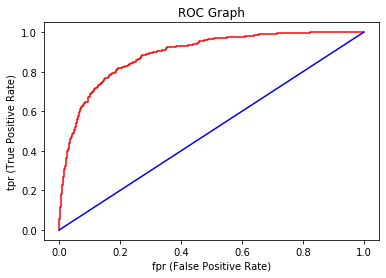

In [49]:
plot_roc(fpr, tpr,"s1_Q4(d).png")
# print("The threshod is: ", thresholds)
print("AUC score (i.e., AUROC): ", metrics.roc_auc_score(y_test, y_predict_prob[:,1]))

In [50]:
# use this function in your solution for 4e, stratify by gender
def stratified_sample(df, column):
    '''
    Returns a stratified sample of df with replacement (stratified by column), with the same number of rows as df.
    '''
    grp = df.groupby(column, group_keys = False)
    return grp.apply(lambda x: x.sample(n = int(np.rint(len(x))), replace = True)).sample(frac=1).reset_index(drop = True)

In [75]:
# Write code for 4e here
# using 1,000 bootstrapped samples of the test set, with gender as the protected variable. Use a decision threshold of 0.3.
# i.e. run [stratified_sample + mertics] for 1000 times
import metrics
importlib.reload(metrics)

ls_of_dict = []

ls_parity_M = []
ls_parity_F = []
ls_specificity_M = []
ls_specificity_F = []
ls_recall_M = []
ls_recall_F = []

test_df = df[df.train == 0] 

for i in range(1000):    # 1,000 bootstrapped samples
    
    #each time stratified_sample will return different order of patients, but still the same size of df
    test_df_stratified = stratified_sample(test_df, 'gender')
    
    # we need the predict probability for df_stratified 
    y_test_stra = test_df_stratified['mort_icu']
    X_test_stra = vectorizer.transform(test_df_stratified['merged_text'])
    
    y_predict_stra = clf.predict(X_test_stra)
    y_predict_prob_stra = clf.predict_proba(X_test_stra)
    
    ls_pred_stra = []
    for i in range (y_predict_prob_stra.shape[0]):
        ls_pred_stra.append(y_predict_prob_stra[i][1])

        
    # add probability to test_df
#     test_df_stratified = test_df_stratified.assign(ls_pred_stra = ls_pred_stra)
    test_df_stratified['ls_pred_stra'] = pd.Series(ls_pred_stra)
    
    ls_of_dict.append(metrics.gap_metrics(test_df_stratified, 'gender', 'mort_icu', 'ls_pred_stra', 0.3))
    
for i in range(len(ls_of_dict)):
    ls_parity_M.append(ls_of_dict[i]['parity']['M'])
    ls_parity_F.append(ls_of_dict[i]['parity']['F'])
    
    ls_specificity_M.append(ls_of_dict[i]['specificity']['M'])
    ls_specificity_F.append(ls_of_dict[i]['specificity']['F'])
    
    ls_recall_M.append(ls_of_dict[i]['recall']['M'])
    ls_recall_F.append(ls_of_dict[i]['recall']['F'])
    
print(len(ls_of_dict))


1000


In [76]:
stra_dict = {"mean of parity_M" : sum(ls_parity_M) / 1000, 
            "mean of parity_F" : sum(ls_parity_F) / 1000,
            "mean of specificity_M" : sum(ls_specificity_M) / 1000,
            "mean of specificity_F" : sum(ls_specificity_F) / 1000,
            "mean of recall_M" : sum(ls_recall_M) / 1000,
            "mean of recall_F" : sum(ls_recall_F) / 1000}
print(stra_dict)

{'mean of parity_M': -0.0022550272182548805, 'mean of parity_F': 0.0022550272182548805, 'mean of specificity_M': 0.00489765562416902, 'mean of specificity_F': -0.00489765562416902, 'mean of recall_M': 0.029900987977574473, 'mean of recall_F': -0.029900987977574473}


In [77]:
import statistics 
  
# Prints standard deviation  
print("Standard Deviation of ls_parity_M is % s " 
                % (statistics.stdev(ls_parity_M))) 
print("Standard Deviation of ls_parity_F is % s " 
                % (statistics.stdev(ls_parity_F)))
print("Standard Deviation of ls_specificity_M is % s " 
                % (statistics.stdev(ls_specificity_M)))
print("Standard Deviation of ls_specificity_F is % s " 
                % (statistics.stdev(ls_specificity_F)))
print("Standard Deviation of ls_recall_M is % s " 
                % (statistics.stdev(ls_recall_M)))
print("Standard Deviation of ls_recall_F is % s " 
                % (statistics.stdev(ls_recall_F)))

Standard Deviation of ls_parity_M is 0.007533554092300888 
Standard Deviation of ls_parity_F is 0.007533554092300888 
Standard Deviation of ls_specificity_M is 0.005735528599101285 
Standard Deviation of ls_specificity_F is 0.005735528599101285 
Standard Deviation of ls_recall_M is 0.05018580464716909 
Standard Deviation of ls_recall_F is 0.05018580464716909 


In [80]:
from scipy import stats 

t_val, p_val = stats.ttest_ind(ls_recall_M, ls_recall_F)
print("For recall gap, t_val, p_val: ", t_val, p_val)

t_val, p_val = stats.ttest_ind(ls_parity_M, ls_parity_F)
print("For parity gap, t_val, p_val: ", t_val, p_val)

t_val, p_val = stats.ttest_ind(ls_specificity_M, ls_specificity_F)
print("For specificity gap, t_val, p_val: ", t_val, p_val)

For recall gap, t_val, p_val:  26.64524049472698 4.222312706924797e-134
For parity gap, t_val, p_val:  -13.386494845197644 3.3596400529847585e-39
For specificity gap, t_val, p_val:  38.18825315505221 4.522522407492755e-240
